# Examine proportion of cortex cells in each developmental zone of bri1-T vs WT

In [1]:
library(tidyverse)
library(Seurat)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(GeneOverlap)
library(gprofiler2)
library(ggrepel)
library(muscat)
library(purrr)
library(limma)
library(scran)
library(future)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject

Loading required package: grid

ComplexHeatmap version 2.11.1
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex hea

In [2]:
#for 200gb ram 
options(future.globals.maxSize = 200000 * 1024^2)

In [3]:
rc.integrated <- readRDS("../data/integrations/rc.integrated_15S_BRZ_bri1_Li_seu3_clean.rds")

In [4]:
rc.integrated

An object of class Seurat 
71252 features across 78435 samples within 3 assays 
Active assay: integrated (17338 features, 17338 variable features)
 2 other assays present: RNA, SCT
 4 dimensional reductions calculated: pca, umap, umap_3D, umap_2D

## Cell type and developmental stage metadata

- Developmental stage: `time_zone`
- Cell type:`cell_type`
- Combination of cell type and developmental stage: `time_zone_cell_type`
- Combination of cell type and developmental stage with cell subtypes (not used): `time_zone_cell_subtypes` 

In [5]:
feature_names <- read_tsv("./data/features.tsv.gz", col_names = c("AGI", "Name", "Type")) %>%
  select(-Type) %>%
  distinct()


── Column specification ────────────────────────────────────────────────────────
cols(
  AGI = col_character(),
  Name = col_character(),
  Type = col_character()
)




In [6]:
table(rc.integrated$genotype)


                   bri1_T pCVP2_BRI1_Citrine_bri1_T      pGL2_BRI1_GFP_bri1_T 
                    12649                     12612                      7878 
                       WT 
                    45296 

In [7]:
# subset samples you want to compare

rc.integrated <- subset(rc.integrated, subset = sample %in% c("sc_130", "sc_134","sc_131","sc_135"))


In [8]:
rc.integrated$genotype <- factor(rc.integrated$genotype, levels=c("WT", "bri1_T"))

In [9]:
table(rc.integrated$time_zone_cell_type, rc.integrated$genotype)

                                   
                                      WT bri1_T
  Distal Columella                  1376    899
  Distal Lateral Root Cap           1669    735
  Elongation_Atrichoblast           1346    462
  Elongation_Cortex                 1354    511
  Elongation_Endodermis              790    538
  Elongation_Pericycle               536    962
  Elongation_Phloem                  102    118
  Elongation_Procambium              313    384
  Elongation_Trichoblast             669    283
  Elongation_Xylem                   354    332
  Maturation_Atrichoblast            612    475
  Maturation_Cortex                  426    320
  Maturation_Endodermis              490    411
  Maturation_Pericycle               183    247
  Maturation_Phloem                   72     80
  Maturation_Procambium              166    189
  Maturation_Trichoblast             845    559
  Maturation_Xylem                    82     90
  Proliferation Domain_Atrichoblast   87   1150
  Pr

In [10]:
sample_num_df <- data.frame(table(rc.integrated$genotype))

sample_num_df <- dplyr::rename(sample_num_df, "total_cells"="Freq", "sample"="Var1")

sample_num_df

rc.integrated$sample.cell.p <- paste(rc.integrated$genotype, rc.integrated$time_zone_cell_type, sep = ",")

sample_cell_df <- data.frame(table(rc.integrated$sample.cell.p))

sample_cell_df <- separate(sample_cell_df, col="Var1", sep=",", into=c("sample", "celltype")) %>%
  dplyr::rename("n_celltype"="Freq")


# there are no cortex proliferation domain cells in this dataset - add column to indicate

df <- data.frame (sample="WT",
    celltype  = "Proliferation Domain_Cortex",
                  n_celltype = 0)

sample_cell_df <- bind_rows(sample_cell_df, df) %>%  
left_join(sample_num_df) %>%
  mutate(proportion=n_celltype/total_cells)

sample_cell_df %>% filter(celltype %in% c("Maturation_Cortex", "Elongation_Cortex", "Transition Domain_Cortex", "Proliferation Domain_Cortex"))

wt_cells <- filter(sample_cell_df, sample == "WT") %>%
  group_by(celltype) %>%
  summarise(wt_prop=mean(proportion))

wt_cells %>% filter(celltype %in% c("Maturation_Cortex", "Elongation_Cortex", "Transition Domain_Cortex", "Proliferation Domain_Cortex"))

wt_cells %>% filter(celltype %in% c("Maturation_Cortex", "Elongation_Cortex", "Transition Domain_Cortex", "Proliferation Domain_Cortex"))

sample,total_cells
<fct>,<int>
WT,14334
bri1_T,12649


Joining, by = "sample"



sample,celltype,n_celltype,total_cells,proportion
<chr>,<chr>,<dbl>,<int>,<dbl>
bri1_T,Elongation_Cortex,511,12649,0.040398450
bri1_T,Maturation_Cortex,320,12649,0.025298443
bri1_T,Proliferation Domain_Cortex,71,12649,0.005613092
bri1_T,Transition Domain_Cortex,402,12649,0.031781168
WT,Elongation_Cortex,1354,14334,0.094460723
WT,Maturation_Cortex,426,14334,0.029719548
WT,Transition Domain_Cortex,97,14334,0.006767127
WT,Proliferation Domain_Cortex,0,14334,0.000000000


celltype,wt_prop
<chr>,<dbl>
Elongation_Cortex,0.094460723
Maturation_Cortex,0.029719548
Proliferation Domain_Cortex,0.000000000
Transition Domain_Cortex,0.006767127


celltype,wt_prop
<chr>,<dbl>
Elongation_Cortex,0.094460723
Maturation_Cortex,0.029719548
Proliferation Domain_Cortex,0.000000000
Transition Domain_Cortex,0.006767127


In [11]:
sample_cell_df <- left_join(sample_cell_df, wt_cells) %>%
  mutate(wt_norm_prop=proportion/wt_prop)

sample_cell_df %>% filter(celltype %in% c("Maturation_Cortex", "Elongation_Cortex", "Transition Domain_Cortex", "Proliferation Domain_Cortex"))

sample_cell_wide <- sample_cell_df %>%
  ungroup() %>%
  select(sample, celltype, wt_norm_prop) %>%
  pivot_wider(names_from = celltype, values_from = wt_norm_prop)

sample_cell_wide

# replace WT proliferation domain NA with 1
sample_cell_wide[is.na(sample_cell_wide)==T] <- 1

sample_cell_wide

cell_order <- tibble(sample=c("WT", "bri1_T"), 
                    order=rep(1:2))

#sample_cell_wide <- filter(sample_cell_wide, sample !="Untreated") 

sample_cell_wide <- left_join(sample_cell_wide, cell_order) %>%
arrange(order) %>%
select(-order)

cell_m <- as.matrix(log2(sample_cell_wide[, -1]))
rownames(cell_m) <- sample_cell_wide$sample

cell_m

cell_m <- t(cell_m)

Joining, by = "celltype"



sample,celltype,n_celltype,total_cells,proportion,wt_prop,wt_norm_prop
<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
bri1_T,Elongation_Cortex,511,12649,0.040398450,0.094460723,0.4276746
bri1_T,Maturation_Cortex,320,12649,0.025298443,0.029719548,0.8512391
bri1_T,Proliferation Domain_Cortex,71,12649,0.005613092,0.000000000,Inf
bri1_T,Transition Domain_Cortex,402,12649,0.031781168,0.006767127,4.6964048
WT,Elongation_Cortex,1354,14334,0.094460723,0.094460723,1.0000000
WT,Maturation_Cortex,426,14334,0.029719548,0.029719548,1.0000000
WT,Transition Domain_Cortex,97,14334,0.006767127,0.006767127,1.0000000
WT,Proliferation Domain_Cortex,0,14334,0.000000000,0.000000000,NaN


sample,Distal Columella,Distal Lateral Root Cap,Elongation_Atrichoblast,Elongation_Cortex,Elongation_Endodermis,Elongation_Pericycle,Elongation_Phloem,Elongation_Procambium,Elongation_Trichoblast,⋯,Proximal Columella,Proximal Lateral Root Cap,Transition Domain_Atrichoblast,Transition Domain_Cortex,Transition Domain_Endodermis,Transition Domain_Pericycle,Transition Domain_Phloem,Transition Domain_Procambium,Transition Domain_Trichoblast,Transition Domain_Xylem
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bri1_T,0.7403762,0.4990479,0.3889628,0.4276746,0.7717318,2.033862,1.310971,1.390267,0.4793707,⋯,0.7015123,1.53559,0.7772292,4.696405,NA,7.17701,NA,NA,0.9592899,18.13139
WT,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.000000,1.000000,1.000000,1.0000000,⋯,1.0000000,1.00000,1.0000000,1.000000,NA,1.00000,NA,NA,1.0000000,1.00000


sample,Distal Columella,Distal Lateral Root Cap,Elongation_Atrichoblast,Elongation_Cortex,Elongation_Endodermis,Elongation_Pericycle,Elongation_Phloem,Elongation_Procambium,Elongation_Trichoblast,⋯,Proximal Columella,Proximal Lateral Root Cap,Transition Domain_Atrichoblast,Transition Domain_Cortex,Transition Domain_Endodermis,Transition Domain_Pericycle,Transition Domain_Phloem,Transition Domain_Procambium,Transition Domain_Trichoblast,Transition Domain_Xylem
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bri1_T,0.7403762,0.4990479,0.3889628,0.4276746,0.7717318,2.033862,1.310971,1.390267,0.4793707,⋯,0.7015123,1.53559,0.7772292,4.696405,1,7.17701,1,1,0.9592899,18.13139
WT,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.000000,1.000000,1.000000,1.0000000,⋯,1.0000000,1.00000,1.0000000,1.000000,1,1.00000,1,1,1.0000000,1.00000


Joining, by = "sample"



,Distal Columella,Distal Lateral Root Cap,Elongation_Atrichoblast,Elongation_Cortex,Elongation_Endodermis,Elongation_Pericycle,Elongation_Phloem,Elongation_Procambium,Elongation_Trichoblast,Elongation_Xylem,⋯,Proximal Columella,Proximal Lateral Root Cap,Transition Domain_Atrichoblast,Transition Domain_Cortex,Transition Domain_Endodermis,Transition Domain_Pericycle,Transition Domain_Phloem,Transition Domain_Procambium,Transition Domain_Trichoblast,Transition Domain_Xylem
WT,0.0000000,0.00000,0.000000,0.000000,0.0000000,0.000000,0.0000000,0.0000000,0.000000,0.00000000,⋯,0.0000000,0.0000000,0.0000000,0.000000,0,0.000000,0,0,0.00000000,0.000000
bri1_T,-0.4336695,-1.00275,-1.362296,-1.225415,-0.3738286,1.024222,0.3906356,0.4753616,-1.060786,0.08785181,⋯,-0.5114598,0.6187931,-0.3635879,2.231557,0,2.843383,0,0,-0.05996127,4.180418


In [12]:
sample_cell_wide <- select(sample_cell_wide, sample, "Maturation"=Maturation_Cortex, "Elongation"=Elongation_Cortex, "Transition Domain"=`Transition Domain_Cortex`, "Proliferation Domain"=`Proliferation Domain_Cortex`) 

sample_cell_wide <- left_join(sample_cell_wide, cell_order) %>%
arrange(order) %>%
select(-order)

sample_cell_wide

cell_m <- as.matrix(log2(sample_cell_wide[, -1]))
rownames(cell_m) <- sample_cell_wide$sample

cell_m

cell_m <- t(cell_m)

Joining, by = "sample"



sample,Maturation,Elongation,Transition Domain,Proliferation Domain
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
WT,1.0000000,1.0000000,1.000000,1
bri1_T,0.8512391,0.4276746,4.696405,Inf


,Maturation,Elongation,Transition Domain,Proliferation Domain
WT,0.0000000,0.000000,0.000000,0
bri1_T,-0.2323636,-1.225415,2.231557,Inf


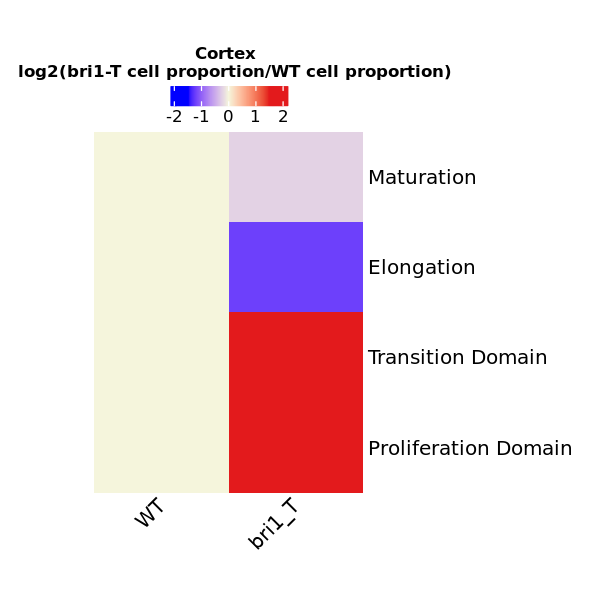

In [13]:
options(repr.plot.width=5, repr.plot.height=5)
# add to hm cell_fun = function(j, i, x, y, width, height, fill) {grid.text(sprintf("%.0f", int_matrix[i, j]), x, y, gp = gpar(fontsize = 10))})

Cell_hm <- Heatmap(cell_m, name = "Cortex \n  log2(bri1-T cell proportion/WT cell proportion)", 
                   heatmap_legend_param = list(title_position="topcenter", 
                                               color_bar = "continuous", 
                                               legend_direction = "horizontal"), 
                   col = colorRamp2(c(-1.5, 0, 1.5), c("blue", "beige", "#e31a1c")), 
                   cluster_rows = F, 
                   cluster_columns = F, 
                   use_raster= FALSE, 
                   column_names_rot = 45,
                   show_column_names = TRUE, show_row_names = TRUE, show_row_dend = TRUE, show_column_dend = TRUE,
                   clustering_distance_rows = "pearson", clustering_distance_columns = "pearson",
                 row_names_gp = gpar(fontsize = 12)) 


draw(Cell_hm, padding = unit(c(10, 20, 10, 10), "mm"), heatmap_legend_side = "top")


In [14]:
pdf("./output/bri1-T_vs_WT_cortex_cell_abundance.pdf", width = 5, height = 5)


# padding - bottom, left, top, right
draw(Cell_hm, padding = unit(c(10, 20, 10, 10), "mm"), heatmap_legend_side = "top")

dev.off()

png 
  2